# Supervised Melanoma Classifiers trained from scrached and using transfer learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch
import torchvision
import PIL

from torch import nn, optim, unsqueeze
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets, models
from PIL import Image

# Detect if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class LabeledDataset(Dataset):
    """Custom Labeled DataSet class for melanoma classification model"""
    
    def __init__(self, dir_path, transform=None):
        """
        Args:
        dir_pat (strin): path to direcory containing the images
        transform (optional): optional transform to be applied
        
        """
        self.dir_path = dir_path
        self.transform = transform
        
        
    def __len__(self):
        """Finds out the total number of samples"""
        file_list = os.listdir(self.dir_path)
        return len(file_list)
    
    def __getitem__(self, i):
        """Import image, get its label and transform to tensor.
           Since files in a directory are not inherently 
           sorted in a particular way, need to grab the 
           file names after sorting the file names by ascending order.
        """
        
        def sort_input_files(self):
            
            file_list = os.listdir(self.dir_path)
            
            separator = "_"
            file_names=[]
            file_exts=[]
            
            for file in file_list:
                
                file_names.append(int(file.split("_")[0]))
                file_exts.append(file.split("_")[1])
            
            sorted_files =[str(name) + separator + ext for (name, ext) in sorted(zip(file_names, file_exts))]
            
            return sorted_files
        
        def get_label(file_name):
            #extract the 5th character from the end of the file name
            file_ext = file_name[-5:-4]
            return torch.tensor(int(file_ext))
        
        img_file = sort_input_files(self)[i]
        label = get_label(img_file)             
        img = Image.open(self.dir_path + img_file)
        
        img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img, label
                

In [3]:
#set path to data folder
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))
data_path = os.path.join(path, parent, 'Data/labeled/')
test_path = os.path.join(path, parent, 'Data/test/')

In [5]:
#Augment the labeled data:
seed = 123
random.seed(seed)
torch.manual_seed(seed)

img_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean = [0.7441, 0.5331, 0.5548],
                                                               std = [0.1464, 0.1557, 0.1735]),
                                    ])

augm_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation(0,360),
                                     img_transform])


labeled_set = LabeledDataset(dir_path= data_path, 
                         transform=img_transform)

test_set = LabeledDataset(dir_path= test_path, 
                          transform=img_transform)                                                

all_datasets = [labeled_set]
for counter in range(5):   
    
    augm_dataset = LabeledDataset(dir_path= data_path, 
                                  transform=augm_transform)
    all_datasets.append(augm_dataset)
    counter += 1

dataset = torch.utils.data.ConcatDataset(all_datasets)  

In [6]:
batch_size = 64

train_set, val_set = random_split(dataset, 
                                  [np.int32(len(dataset)*0.8), np.int32(len(dataset)*0.2)],
                                  generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_set,
                          batch_size = batch_size,
                          shuffle = True, 
                          num_workers = 0)
    
val_loader =  DataLoader(val_set,
                         batch_size = batch_size,
                         shuffle = True, 
                         num_workers = 0) 
    
test_loader = DataLoader(test_set,
                         batch_size = 16,
                         shuffle = False, 
                         num_workers = 0) 

print("training data contains the augmented {} labeled images".format(len(train_loader.dataset)))
print("validation data constain the original {} labeled images".format(len(val_loader.dataset)))
print("test data constain of {} labeled images".format(len(test_loader.dataset)))

training data contains the augmented 960 labeled images
validation data constain the original 240 labeled images
test data constain of 600 labeled images


In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2)
        self.fc1   = nn.Linear(64*5*5, 256)
        self.fc2   = nn.Linear(256, 2)
        
    def forward(self, x):
        out = F.max_pool2d(F.relu(self.conv1(x)),   kernel_size=2, stride=2)
        out = F.max_pool2d(F.relu(self.conv2(out)), kernel_size=2, stride=2)
        out = F.max_pool2d(F.relu(self.conv3(out)), kernel_size=2, stride=2)
        out = out.view( -1, 64*5*5)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out            

In [8]:
def training_loop(num_epochs, optimizer, model, loss_fn, train_loader):
    """ Run the model through the entire dataset multiple times with a for loop"""
    
    # Set model to training mode
    model.train() 
    
    train_loss =[]
    train_acc_hist = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        running_loss = 0.0
        running_correct = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # zero the parameter gradients to clear the adjustments of the weights
            optimizer.zero_grad()
            
            #forward pass to get output/logits
            outputs = model(images) 
            
            preds = torch.argmax(outputs,1)
            
            loss = loss_fn(outputs, labels)
    
            
            # Getting gradients w.r.t. parameters 
            loss.backward()
            
            # Updating parameters when adjusting the weights
            optimizer.step()
            
            # add the loss to the training set's running loss
            running_loss += loss.item()*images.size(0)  
            running_correct += torch.sum(preds == labels.data) 
            
        epoch_loss = running_loss/len(train_loader.dataset)
        epoch_acc  = running_correct.double()/len(train_loader.dataset) #running_correct.double()
        
        train_loss.append(epoch_loss)
        train_acc_hist.append(epoch_acc)
        
        print("Trianing Loss: {:.4f} Acc: {:.4f}".format(epoch_loss, epoch_acc))
        print()
    
    #conver cuda tensor to a list on cpu in order to plot
    train_acc_hist = torch.tensor(train_acc_hist, device='cpu')
    
    plt.plot(train_loss, label='Training Loss')
    plt.plot(train_acc_hist, label='Training Accuracy')
    plt.legend(frameon=False)
    plt.title('Model Training Accuracy')
    plt.show()
    
    return train_acc_hist
    

In [9]:
def validate(model, loader):
    
    model.eval()
    
    total = 0
    correct = 0
        
    with torch.no_grad():
        
        for images, labels in loader:
            # Move to device
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            total += labels.shape[0]
            correct += int((preds ==labels).sum())
                
    print("Validation Accuracy: {:.2f}".format(correct/total)) 

In [10]:
model = Classifier()

numel_list = [p.numel() for p in model.parameters()]
print("total number of model parameters:", sum(numel_list))
print("model parameters per layer:", numel_list)

# move model to device
model.to(device)

total number of model parameters: 439010
model parameters per layer: [864, 32, 9216, 32, 18432, 64, 409600, 256, 512, 2]


Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [11]:
# set the error function
loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.001 
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
num_epochs = 50
class_names = ["bening",  "malignant"]

In [13]:
# check if the model runs on the gpu
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)
model(images[1].unsqueeze(0))

tensor([[-0.0410,  0.0538]], device='cuda:0', grad_fn=<AddmmBackward>)

Epoch 0/49
----------
Trianing Loss: 0.6926 Acc: 0.5042

Epoch 1/49
----------
Trianing Loss: 0.6889 Acc: 0.5042

Epoch 2/49
----------
Trianing Loss: 0.6846 Acc: 0.5240

Epoch 3/49
----------
Trianing Loss: 0.6797 Acc: 0.6219

Epoch 4/49
----------
Trianing Loss: 0.6743 Acc: 0.6792

Epoch 5/49
----------
Trianing Loss: 0.6679 Acc: 0.7323

Epoch 6/49
----------
Trianing Loss: 0.6599 Acc: 0.7594

Epoch 7/49
----------
Trianing Loss: 0.6488 Acc: 0.7656

Epoch 8/49
----------
Trianing Loss: 0.6349 Acc: 0.7708

Epoch 9/49
----------
Trianing Loss: 0.6166 Acc: 0.7896

Epoch 10/49
----------
Trianing Loss: 0.5939 Acc: 0.7937

Epoch 11/49
----------
Trianing Loss: 0.5669 Acc: 0.7948

Epoch 12/49
----------
Trianing Loss: 0.5397 Acc: 0.7844

Epoch 13/49
----------
Trianing Loss: 0.5167 Acc: 0.7802

Epoch 14/49
----------
Trianing Loss: 0.4999 Acc: 0.7833

Epoch 15/49
----------
Trianing Loss: 0.4874 Acc: 0.7844

Epoch 16/49
----------
Trianing Loss: 0.4765 Acc: 0.7990

Epoch 17/49
----------
T

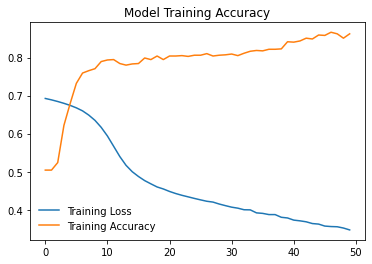

In [14]:
train_acc_history = training_loop(num_epochs = num_epochs, 
                                  optimizer = optimizer, 
                                  model = model, 
                                  loss_fn = loss_fn, 
                                  train_loader = train_loader)

In [15]:
# Supervised Melanoma Classifier performance on validation data set
validate(model, val_loader)

Validation Accuracy: 0.83


In [16]:
# Supervised Melanoma Classifier performance on test data set
validate(model, test_loader)

Validation Accuracy: 0.77


In [17]:
# save model weights
torch.save(model.state_dict(), path + "/melanoma_classifier_1200.pt")

In [18]:
def get_batch_dims(batch):
    """ Helper function returning returning the batch number, 
        the images within the batch and their labels if labeled. """ 
    
    batch_idx = batch[0]
    
    if len(batch[1])==2:
        
        images = batch[1][0]
        labels = batch[1][1]
        batch_size = len(images)
        
    else:
        
        images = batch[1]
        batch_size = len(images)
        labels = [" "] * batch_size
        
    return batch_idx, images, labels

In [19]:
def show_batch_images(model, data_loader, batch_num, nrows=4, ncols=4):
    
    """ Helper function for displaying images of a given batch number
        with their labels and predicted labels """
    
    try:
        if batch_num >= len(data_loader):
            raise ValueError("Choose a valid batch number less than or equal to {} ".format(len(data_loader)))
    except ValueError as err:
        print(err)
    
    
    model.eval()
    class_names = ["bening", "malignant"]
    
    with torch.no_grad():
        
        for batch in enumerate(data_loader):
            
            batch_idx, images, labels = get_batch_dims(batch) 
            images = images.to(device)
            labels = labels.to(device)
        
            if batch_idx == batch_num:
                
              outputs = model(images)
              preds = torch.argmax(outputs, dim=1)  
            
              fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
              fig.suptitle("Images of batch number {}".format(batch_idx), fontsize=14)
    
              n = 0 
              for i in range(nrows):
                
                for j in range(ncols):
                    
                    img_idx = i + j + (ncols-1)*n
                    
                    if labels[img_idx] == " " :
                        ground_truth = " "
                    else :
                        ground_truth = class_names[int(labels[img_idx])]
                    
                    img_labels = ground_truth + "\n predicted: " + class_names[int(preds[img_idx])]
                   
                    img_tensor = images.cpu().data[img_idx]
                    # Un-normalize image tensor and convert into numpy array 
                    img_array = img_tensor.numpy().transpose((1, 2, 0))
                    
                    mean = np.array([0.7441, 0.5331, 0.5548])
                    std = np.array([0.1464, 0.1557, 0.1735])
                    
                    img_array = std * img_array + mean
                    img_array = np.clip(img_array, 0, 1)
                    
                    axes[i,j].imshow(img_array)
                    
                    axes[i,j].set_title(img_labels, fontsize=10)
                    axes[i,j].axis('off')
        
                n += 1

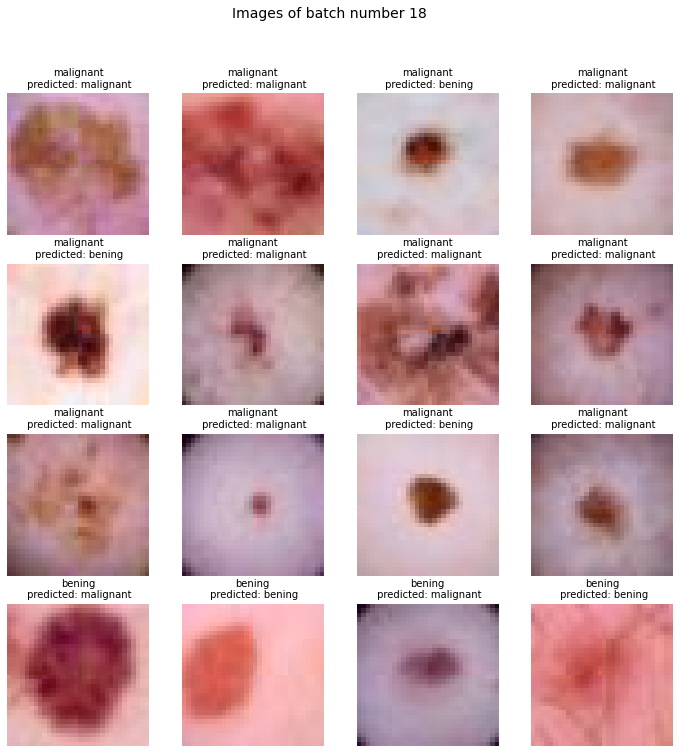

In [20]:
show_batch_images(model, test_loader, batch_num=18)

## Melanoma Classifier build with transfer learnning

There are two types of transfer learning: finetuning and feature extraction. **Finetuning** starts with a pretrained model and update all of the model’s parameters for the new task. In **feature extraction**, we start with a pretrained model and only update the final layer weights from which we derive predictions. 

Here we use the torchvision models ResNet and DenseNet which have been pretrained on the 1000-class Imagenet dataset.

ResNet and DenseNet architectures can alleviate the vanishing gradient problem and strengthen feature propagation through the network. Choose the shallower depths of ResNet-18 of the ResNet model and DenseNet-121 for the DenseNet model to prevent overfitting of the limited labeled melanoma data for training.

In [21]:
num_classes = 2

image_datasets = {'train': train_set,
                  'val'  : val_set,
                  'test' : test_set}

# Create train, validation and test dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x], 
                                  batch_size=batch_size, 
                                  shuffle=True, 
                                  num_workers=0) for x in image_datasets.keys()}

    
for k in dataloaders_dict.keys():
    print("{} dataset number of images {}".format(k,len(dataloaders_dict[k].dataset)))

train dataset number of images 960
val dataset number of images 240
test dataset number of images 600


### Define helper functions

In [22]:
def train_val_model(model, dataloaders, loss_fn, optimizer, num_epochs=25):
    
    """ Function that handles the training and validation of a given model. 
        As input, it takes a PyTorch model, a dictionary of dataloaders, 
        a loss function, an optimizer, a specified number of epochs to train 
        and validate for after each epoch runs a full validation step. """
    
    model.train()
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # foraward; track history if training
                with torch.set_grad_enabled(phase == 'train'):
                    # get model outputs and calculate loss
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    predicted = torch.argmax(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # statistics
                    running_loss += loss.item() * images.size(0)
                    running_corrects += torch.sum(predicted == labels.data)  
        
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
        print()

        
    return model, val_acc_history

In [23]:
def set_parameter_requires_grad(model, feature_extracting):
    
    """ Helper function which sets the .requires_grad attribute of the parameters 
        in the model to False for feature extracting. When loading a pretrained model 
        all of the parameters have .requires_grad=True by default, which is for 
        # training from scratch or finetuning. If feature extracting is needed and 
        only want to compute gradients for the newly initialized layer then we all 
        of the other parameters to not require gradients. """
    
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### Initialize the pre-train models

In [24]:
def initialize_model(model_name, num_classes, features_extract, use_pretrained=True):
    
    """Reshape the last layer of the network to have the same number of outputs as
       the number of classes in the dataset.after loading the pretrained model, 
       but before reshaping, if feature_extract=True, manually set all of the 
       parameter’s .requires_grad attributes to False. Reinitialized layer’s 
       parameters have .requires_grad=True by default """
    
    # Initialize each of these variables which are model specific.
    model_ft = None
    input_size = 0
    
    if model_name == "ResNet18":
        """ Resnet18
            ResNet has a special building block called residual block with 
            skip connections between the input and the output layer in each block.
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 32
        
    elif model_name == "DenseNet121":
        """ Densenet121
            DenseNet’s architecture consists of dense blocks that connect
            each layer to all other layers in a feed-forward fashion
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 32
        
    return model_ft, input_size

### Optimizer that only updates the desired parameters 

The optimizer only updates the desired parameters marked with .requires_grad=True. A list of such parameters is an input to the SGD algorithm constructor: finetuning - update all parameters, feature extract - only update the parameters with requires_grad True.
NB: A learning rate scheduler can be used to decreases the learning rate of the optimizer overtime and helps prevent non-convergence due to large learning rates.

In [25]:
# Set feature extracting flag to False for fine tuning, 
# set to True when only update the reshaped layer params
feature_extract = True

### Training and Validation

In [26]:
def performance_acc(model):
    
    model.eval()
    
    for phase in image_datasets.keys():
        
        correct = 0
        
        with torch.no_grad():
            # Iterate over data
            for images, labels in dataloaders_dict[phase]:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                predicted = torch.argmax(outputs, dim=1)
                correct += int((predicted ==labels).sum())
                
        print("Accuracy {}: {:.2f}".format(phase, correct/len(dataloaders_dict[phase].dataset)))

In [27]:
#for model_name  in ["ResNet18", "DenseNet121"]:
def  run_pretrained_model(model_name):   
    
    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, 
                                            num_classes, 
                                            feature_extract, 
                                            use_pretrained=True)

    # Print the initslized model
    print(model_ft)
    
    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized
    params_to_update = model_ft.parameters()
    print("Parameters to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
        else:
            for name,param in model_ft.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)

    # All parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Set up the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft, hist = train_val_model(model_ft, 
                                     dataloaders_dict, 
                                     loss_fn, 
                                     optimizer_ft, 
                                     num_epochs=num_epochs)
    return model_ft, hist

In [28]:
# Train and evaluate Resnet18 and DenseNet121
rn18,  rn18_hist  = run_pretrained_model("ResNet18") 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

val Loss: 0.2133 Acc: 0.9125

Epoch 42/49
----------
train Loss: 0.2362 Acc: 0.8990
val Loss: 0.1939 Acc: 0.9208

Epoch 43/49
----------
train Loss: 0.2386 Acc: 0.8990
val Loss: 0.2061 Acc: 0.9417

Epoch 44/49
----------
train Loss: 0.2542 Acc: 0.8875
val Loss: 0.2059 Acc: 0.9167

Epoch 45/49
----------
train Loss: 0.2638 Acc: 0.8958
val Loss: 0.2094 Acc: 0.9083

Epoch 46/49
----------
train Loss: 0.2498 Acc: 0.8896
val Loss: 0.2162 Acc: 0.9333

Epoch 47/49
----------
train Loss: 0.2468 Acc: 0.8969
val Loss: 0.2413 Acc: 0.9167

Epoch 48/49
----------
train Loss: 0.2199 Acc: 0.9135
val Loss: 0.2092 Acc: 0.9167

Epoch 49/49
----------
train Loss: 0.2320 Acc: 0.9042
val Loss: 0.2750 Acc: 0.8917



In [29]:
#Train and evaluate DenseNet121
dn121, dn121_hist = run_pretrained_model("DenseNet121")

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

train Loss: 0.7589 Acc: 0.4937
val Loss: 0.6359 Acc: 0.6750

Epoch 1/49
----------
train Loss: 0.5611 Acc: 0.7312
val Loss: 0.5254 Acc: 0.7833

Epoch 2/49
----------
train Loss: 0.4580 Acc: 0.7948
val Loss: 0.4315 Acc: 0.8375

Epoch 3/49
----------
train Loss: 0.4162 Acc: 0.8146
val Loss: 0.4126 Acc: 0.8250

Epoch 4/49
----------
train Loss: 0.3649 Acc: 0.8583
val Loss: 0.3921 Acc: 0.8500

Epoch 5/49
----------
train Loss: 0.3605 Acc: 0.8604
val Loss: 0.3430 Acc: 0.8625

Epoch 6/49
----------
train Loss: 0.3381 Acc: 0.8792
val Loss: 0.3712 Acc: 0.8500

Epoch 7/49
----------
train Loss: 0.3156 Acc: 0.8885
val Loss: 0.3479 Acc: 0.8958

Epoch 8/49
----------
train Loss: 0.3142 Acc: 0.8833
val Loss: 0.3136 Acc: 0.8708

Epoch 9/49
----------
train Loss: 0.2976 Acc: 0.8927
val Loss: 0.3122 Acc: 0.8792

Epoch 10/49
----------
train Loss: 0.2729 Acc: 0.9135
val Loss: 0.3230 Acc: 0.8750

Epoch 11/49
----------
train Loss: 0.2898 Acc: 0.8906
val Loss: 0.2676 Acc: 0.8958

Epoch 12/49
----------
t

## Comparison of supervised melanoma classifier build from scratch with the pre-trained ResNet18 and DenseNet121

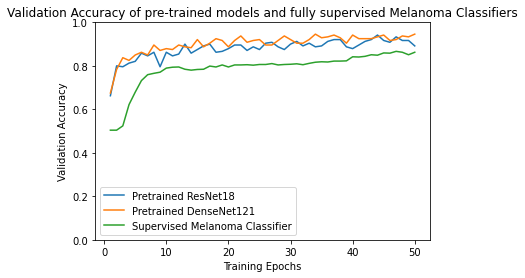

In [37]:
#move cuda tensor onto cpu in order to plot
train_acc_history = train_acc_history.clone().detach()
rn18_hist = rn18_hist.clone().detach()
dn121_hist = dn121_hist.clone().detach()

# Plot the training curves of validation accuracy vs. number of training epochs for the ResNet18 and DenseNet121
plt.title("Validation Accuracy of pre-trained models and fully supervised Melanoma Classifiers")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, num_epochs+1),rn18_hist,label = "Pretrained ResNet18")
plt.plot(range(1, num_epochs+1),dn121_hist,label = "Pretrained DenseNet121")
plt.plot(range(1, num_epochs+1),train_acc_history,label = "Supervised Melanoma Classifier")
plt.ylim((0,1.))
plt.legend()
plt.show()

In [38]:
#Feature Extractor ResNet18 as Melanoma Classifier
performance_acc(rn18)

Accuracy train: 0.93
Accuracy val: 0.90
Accuracy test: 0.73


In [39]:
#Feature Extractor DenseNet121 as Melanoma Classifier
performance_acc(dn121)

Accuracy train: 0.96
Accuracy val: 0.95
Accuracy test: 0.76


In [40]:
# Supervised Melanoma Classifier trained from scratch
performance_acc(model)

Accuracy train: 0.87
Accuracy val: 0.83
Accuracy test: 0.77


## Summary of the current state-of-the art semi-supervied machine learning for computer vision

Semi-supervised learning (SSL) seeks to largely alleviate the need for labeled data by allowing a model to use both labeled and unlabeled samples, assuming that unlabeled data comes from the same distribution as labeled data. Semi-supervised learning adds a loss term which is computed on unlabeled data and encourages the model to generalize better to unseen data. Depending on the type of loss term, according to D. Berthelot "Mixmatch: A holistic approach to semi-supervised learning" there are three main approaches:

* **consistency regularization** labels should not change despite adding noise, thus encourages the model to produce the same output distributions when its inputs are perturbed - Π-Model, Temporal Ensembling, Mean Teacher, Virtual Adversarial Training, Unsupervised Data Augmentation

* **entropy minimization** reduce randomness, i.e. encourages the model to make confident predictions on unlabeled data - Pseudo-labeling, 

* **generic regularization** encorages the model to generalize well and avoid overfitting to small labeled dataset - Adaptive weight decay, MixUp

Other SSL technique like Self-Supervised learning where a model is trained on labeled data and used to predict pseudo-labels for the unlabeled data and then trained on both ground truth labels and pseudo-labels simultaneously, along with additionalcomponents for performance improvement are combined in the SSL **hybrid methods**:

**MixMatch** guesses low-entropy labels for data-augmented un-
labeled examples and mixes labeled and unlabeled data using MixUp. Stochastic data augmentation is applied to an unlabeled image K times, and each augmented image is fed through the classifier. The average of these K predictions is “sharpened” by adjusting the distribution’s temperature to get the final pseudo-label, which is used for all K-augmentations. 

**FixMatch** is a combination of two common SSL methods: consistency regularization and pseudo-labeling. The algorithm first generates pseudo-labels using the model’s predictions on weakly-augmented unlabeled images. For a given image, the pseudo-label is only retained if the model produces a high-confidence prediction compared to a threshold, then the model is trained to predict the pseudo-label when fed a strongly-augmented version of the same image. This prediction is compared to ground truth pseudo-label using cross-entropy loss. Both the losses are combined and the model is optimized